## Exploring the Relationship Between Energy Usage and Overall Development

The rapid technological changes in recent decades has increased the quality of life and overall development globally.  From better access to clean water to greater numbers of college educated people with regular internet access, people are living better and longer than ever.  The cost of these improvements can perhaps best be quantified in terms of energy usage as opposed to simple monetary costs.  The most modern tools we use don't just consume more and produce more than their older counterparts, they product more per unit energy used.  Knowing this, we would expect global development to be strongly correlated to enery usage.  Let's see if this hypotheses is true.


The data we will use is provided by the World Bank.  It has been slightly modified and converted into a SQLite database.  The respective links are posted below:

https://www.kaggle.com/worldbank/world-development-indicators

http://data.worldbank.org/data-catalog/world-development-indicators

The database is a collection of development indicators, compiled from officially recognized international sources. It presents the most current and accurate global development data available and includes national, regional and global estimates.

There are 1344 distinct indicators in this database.  There's no end to the possibile ways of defining a nation's level of overall development and qualify of life.  Here are some indicators that represent important characteristics of a country:

1. Alternative and nuclear energy (% of total energy use)
2. Improved water source (% of population with access)
3. Life expectancy at birth, total (years)
4. GDP per capita, PPP (current international $)
5. Labor force with tertiary education (% of total)
6. GDP per unit of energy use (PPP dollar per kg of oil equivalent) 
7. Exports of goods and services (constant 2005 USdollar)
8. GNI, PPP (current international dollar) 

Ultimately, we want to relate these indicators to how much the energy is used per capita.  For this, we will use the following indicator:

Energy use (kg of oil equivalent per capita) 


In [1]:
#Import Basic Packages
import numpy as np
import pandas as pd
import sqlite3
from pandas import Series,DataFrame

# These are the plotting modules and libraries we'll use:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Import for Linear Regression
import sklearn
from sklearn.linear_model import LinearRegression

# Command so that plots appear in the iPython Notebook
%matplotlib inline

In [2]:
#Establish Connection to SQLite Database
con = sqlite3.connect('Documents/Python/world-development-indicators/database.sqlite')


#### We're really only interested in recent history, so for now we'll focus on data beyond and including the year 2000. Here is the SQL query to pull the relevant data.

In [3]:
#Define SQL Query
#We're really only interestd in recent history, so for now we'll focus on data beyond and including the year 2000.
Indicators = '''

SELECT I.CountryName, C.Region, C.IncomeGroup, I.IndicatorName, I.Year, I.Value
FROM INDICATORS I
LEFT JOIN COUNTRY C on I.CountryCode = C.CountryCode
WHERE YEAR >= 2000
AND  IndicatorName in 
(
 'Alternative and nuclear energy (% of total energy use)'
,'Energy use (kg of oil equivalent per capita)'
,'GDP per capita, PPP (current international $)'
,'Improved water source (% of population with access)'
,'Labor force with tertiary education (% of total)'
,'Life expectancy at birth, total (years)'
,'Internet users (per 100 people)'
)

'''

#Create Dataframe and show sample
Indicators_Raw = pd.read_sql(Indicators,con)
Indicators_Raw.head()


,CountryName,Region,IncomeGroup,IndicatorName,Year,Value
0,Arab World,,,Alternative and nuclear energy (% of total ene...,2000,0.519853
1,Caribbean small states,,,Alternative and nuclear energy (% of total ene...,2000,0.072300
2,Central Europe and the Baltics,,,Alternative and nuclear energy (% of total ene...,2000,9.569305
3,East Asia & Pacific (all income levels),,,Alternative and nuclear energy (% of total ene...,2000,7.589732
4,East Asia & Pacific (developing only),,,Alternative and nuclear energy (% of total ene...,2000,3.192371


#### In an ideal situation, we would have data for every indicator in every year.  Unfortunately, we're missing many indicators entirely for 2014 and 2015.  Otherwise, the least known entity is energy usage per capital in 2013, as we only have values from 40 countries.  For now, let's exclude these years from our analysis.   

In [4]:
Indicators_Raw.drop(Indicators_Raw[Indicators_Raw.Year >= 2014].index, inplace = True)

#### Another feature of this dataset that we need to account for is when the region is blank.  We can see that corresponding country names for blank regions are not countries at all.  They include values such as 'World', 'Low Income' and 'Euro Asia'.  These values group countries into various categories, so let's excude them so we don't incorporate them into our analysis as if they were actual countries

In [5]:
Indicators_Raw.drop(Indicators_Raw[Indicators_Raw.Region == ''].index, inplace = True)

#### Now let's create a new Dataframe as a pivoted version of the original.  This will allow for much easier analysis.

In [7]:
#Convert Indicators into Columns
Indicators_df = Indicators_Raw.set_index(
    ['Year', 'Region', 'IncomeGroup', 'CountryName', 'IndicatorName']).unstack('IndicatorName')


#Reformat Columns
Indicators_df.reset_index(level =  ['Year', 'Region', 'IncomeGroup', 'CountryName'], inplace = True)

Indicators_df.columns = [' '.join(col).strip() for col in Indicators_df.columns.values]
Indicators_df.columns = [col.strip('Value ') if col not in ('Year', 'CountryName') else col for col in Indicators_df.columns]
Indicators_df.head(5)

,Year,Region,IncomeGroup,CountryName,Alternative and nuclear energy (% of total energy use),Energy use (kg of oil equivalent per capita),"GDP per capita, PPP (current international $)",Improved water source (% of population with access),Internet users (per 100 people),Labor force with tertiary education (% of total),"Life expectancy at birth, total (years)"
0,2000,East Asia & Pacific,High income: OECD,Australia,1.384669,5644.064951,26331.654088,100.0,46.756116,27.600000,79.234146
1,2000,East Asia & Pacific,High income: OECD,Japan,18.377030,4091.710027,25938.195214,100.0,29.990740,35.000000,81.076098
2,2000,East Asia & Pacific,High income: OECD,"Korea, Rep.",15.298366,4002.671284,18091.485461,93.4,44.700000,24.000000,75.835366
3,2000,East Asia & Pacific,High income: OECD,New Zealand,23.769919,4428.734220,21567.594491,100.0,47.379557,33.200001,78.636585
4,2000,East Asia & Pacific,High income: nonOECD,Brunei Darussalam,0.000000,7213.665543,59253.677433,NaN,8.996285,NaN,75.288805


#### Let's now create a new dataframe that removes all rows from the dataframe where at least one indicator value is unknown. 

In [8]:
Indicatorsnn_df = Indicators_df.dropna()

#### Let's see how the mean of each indicator changes over time.

In [9]:
Indicators_df.groupby(['Year']).mean().pct_change()

,Alternative and nuclear energy (% of total energy use),Energy use (kg of oil equivalent per capita),"GDP per capita, PPP (current international $)",Improved water source (% of population with access),Internet users (per 100 people),Labor force with tertiary education (% of total),"Life expectancy at birth, total (years)"
Year,,,,,,,
2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,0.083511,0.023001,0.028679,0.005164,0.231586,0.003406,0.004272
2002,-0.054279,0.009951,0.029949,0.005347,0.272788,0.064430,0.005835
2003,-0.015490,0.024745,0.040378,0.005107,0.191797,0.029869,0.002335
2004,0.008284,-0.118370,0.073480,0.005105,0.149303,0.072920,0.005614
2005,0.008803,-0.005284,0.055100,0.004966,0.116667,-0.085014,0.004388
2006,-0.017125,0.026711,0.082928,0.004965,0.124097,0.052417,0.005748
2007,-0.015526,0.003524,0.061529,0.006404,0.087631,0.006489,0.005410
2008,0.002076,0.158537,0.032752,0.004219,0.111413,0.015556,0.005314


#### We can see that as a whole, these indicators do not change rapidly globally from year to year.  

#### Through visualization, we can spot some general trends and patterns among this data set.  Let's see how the various income groups compare with each other through a histograms and lineplots.

In [10]:
def ExploreData(group):
    df = Indicatorsnn_df
    columns = df.groupby(['Year']).mean().columns
    var = Series.unique(df[group])
    outercount = 0
    innercount = 0
    titlesize = 35
    axeslabelsize = 40
    ticksize = 28
    legendsize = 25
    fig, ax = plt.subplots(len(columns),2,figsize=(40,130))
    for i in range(len(columns)):
        ax[i,0].plot(df.groupby(['Year']).mean().index, 
                df.groupby(['Year']).mean()[columns[outercount]], 
                    linewidth = 7,
                    label = 'Total')
        ax[i,1].hist(df[columns[outercount]],
                    alpha = .15, 
                    bins = 20,
                    label = 'Total')
        plt.subplots_adjust(hspace = .5)
        ax[i,0].set_title(columns[outercount] + '\n', fontsize = titlesize, fontweight = 'bold')
        ax[i,1].set_title(columns[outercount] + '\n', fontsize = titlesize, fontweight = 'bold')
        ax[i,0].set_xlabel('\n Year', fontsize = axeslabelsize)
        ax[i,1].set_xlabel('\n Value', fontsize = axeslabelsize)
        ax[i,1].set_ylabel('Count', fontsize = axeslabelsize)
        ax[i,0].tick_params(labelsize=ticksize)
        ax[i,1].tick_params(labelsize=ticksize)
        for y in var:
            ax[i,0].plot(df[df[group] == y]
                    .groupby(['Year']).mean()[columns[outercount]]
                    ,linewidth = 4 
                    ,label = y)
            ax[i,0].legend(loc='upper left', shadow=True, prop= {'size':legendsize})
            ax[i,1].hist(df[df[group]==y][columns[outercount]],
                        alpha = .40,
                        bins = 20,
                        label = y)
            ax[i,1].plot
            ax[i,1].legend(loc='upper left', shadow=True, prop= {'size':legendsize})
            innercount = innercount +1
        outercount = outercount + 1

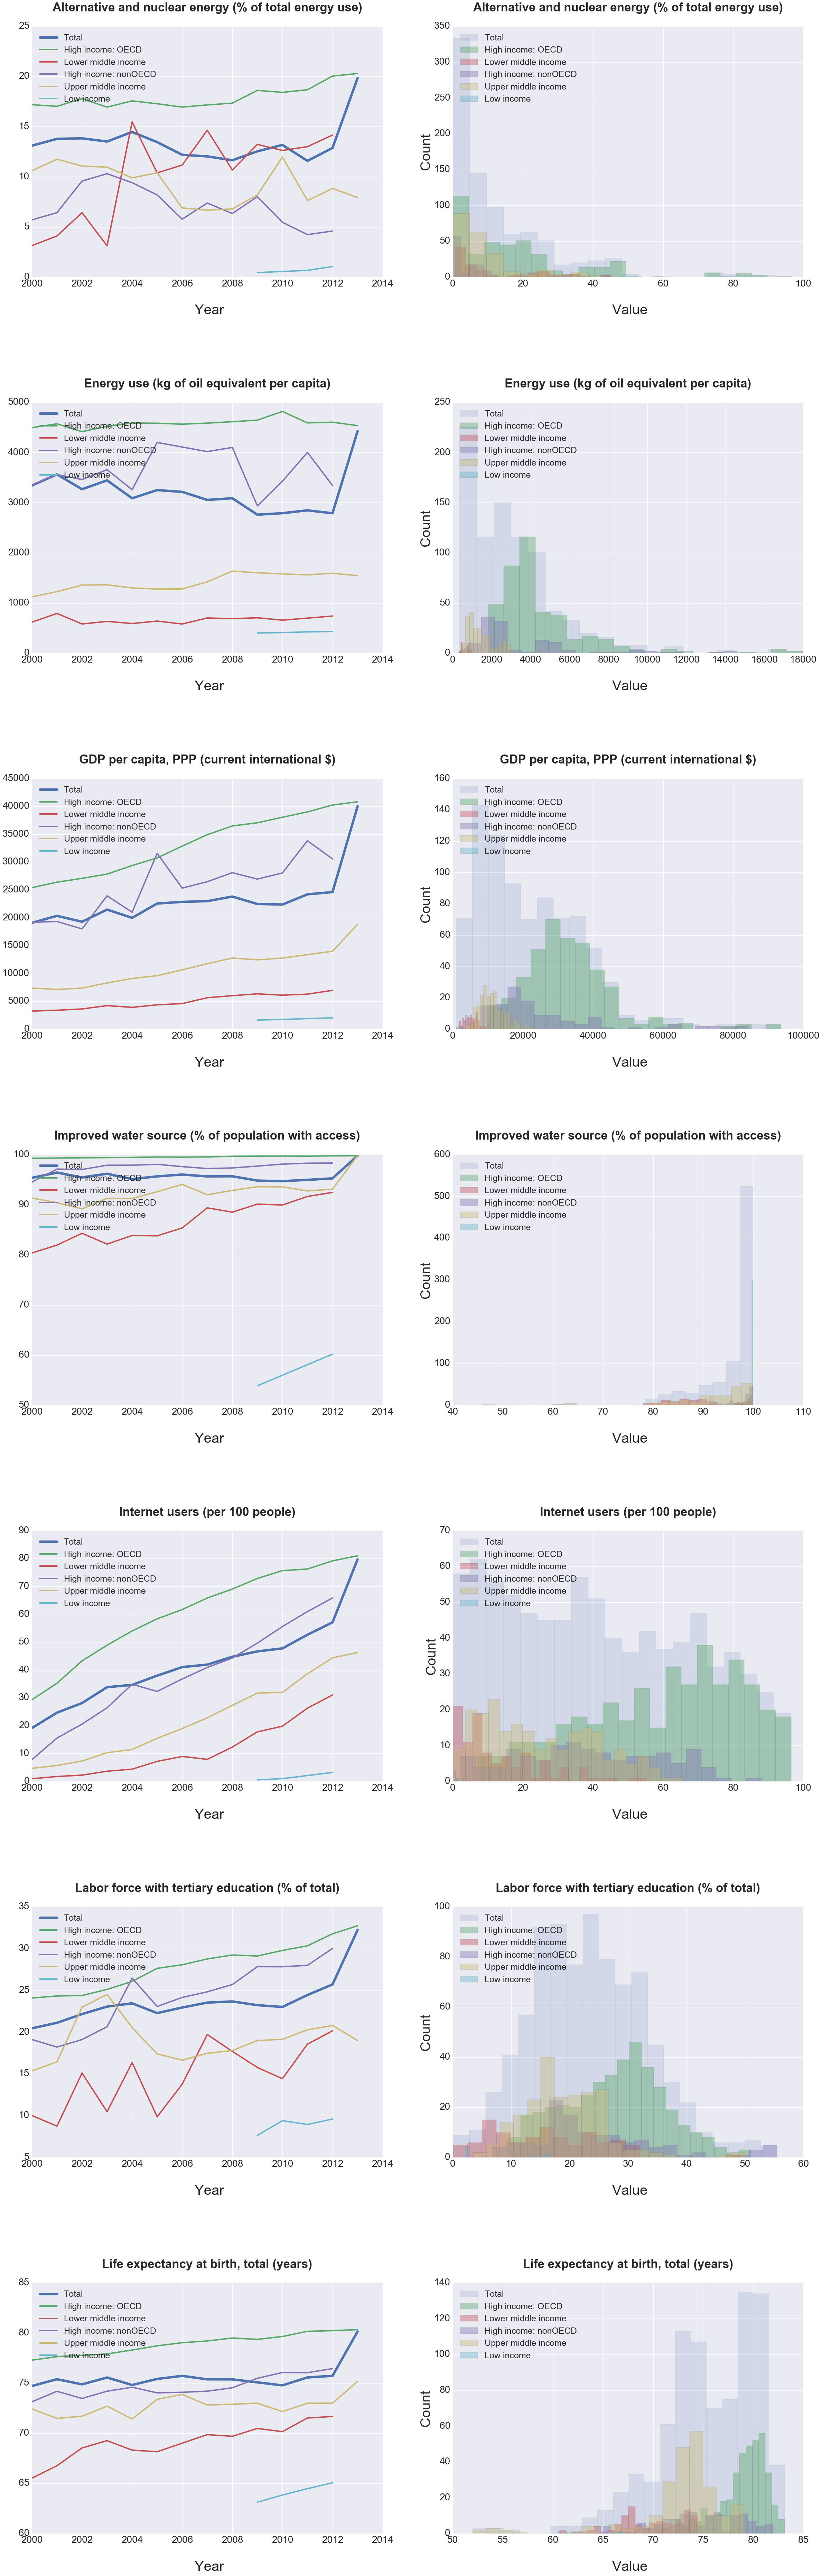

In [11]:
ExploreData('IncomeGroup')

#### Not surprisingly, the higher income countries have higher values for all indicators shown here.   It's important to note that in more recent years, the global average of all indicators spikes.  A naive observer would assume that that global development spikes in the year 2012.  A closer look will reveal that the global (Total) values are heavily distorted by the our lack of data among lower middle income and low income countries.  

#### The right column is a representation of the distributon of values and how often they occur, grouped by incomegroup.  One noteworthy obervation of these histograms is the large number of high income countries represented.  It's clear that higher income countries outnumber less wealthy ones, at least according to the World Bank's definition of wealth.

#### Let's take a similar look, but this time focusing in on geographical region.

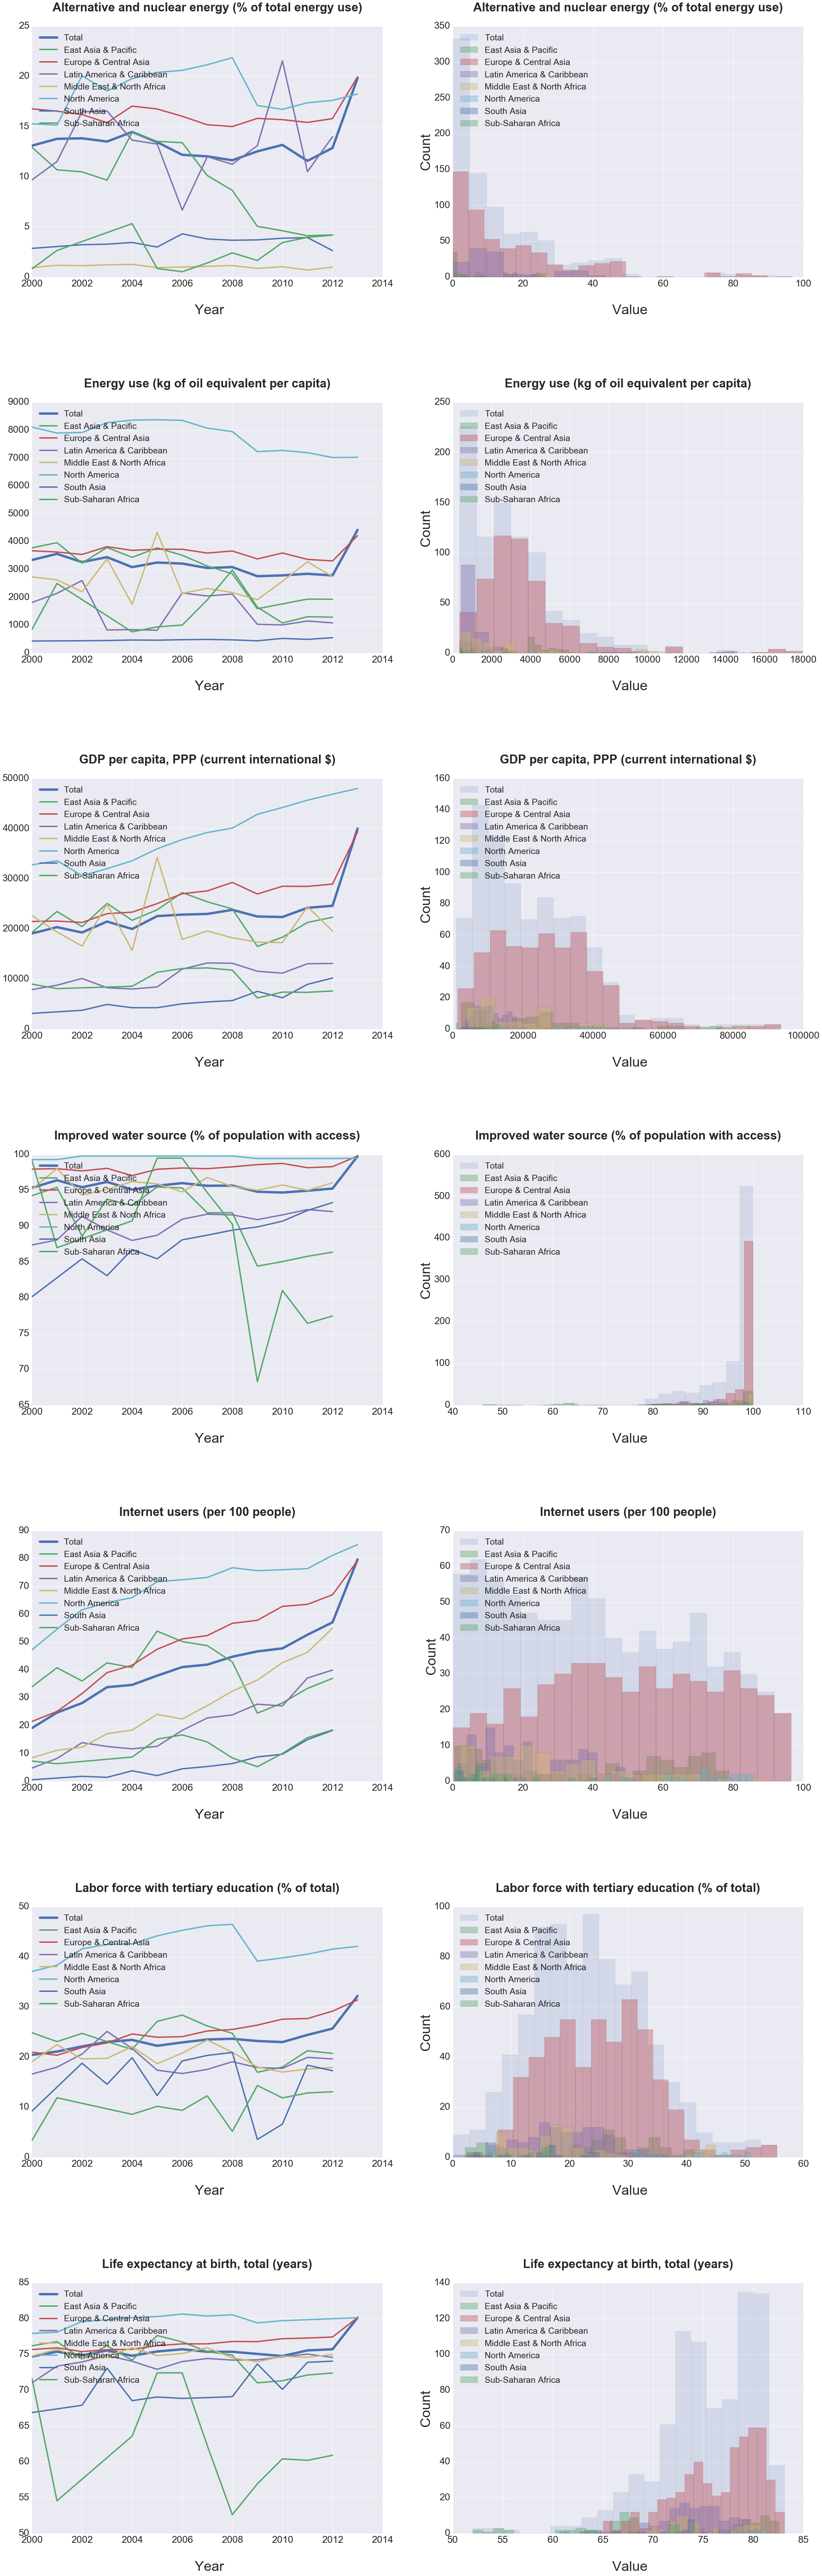

In [13]:
ExploreData('Region')

#### Not surprisingly, we can see that North America has the highest values for all indicators, especially in energy usage.

#### Europe and Central Asia is by far the most reprented region.

#### Now let's take a look at how these indicators relate to each other.

In [19]:
Indicators_df.drop('Year',axis = 1).corr(method = 'pearson') 

,Alternative and nuclear energy (% of total energy use),Energy use (kg of oil equivalent per capita),"GDP per capita, PPP (current international $)",Improved water source (% of population with access),Internet users (per 100 people),Labor force with tertiary education (% of total),"Life expectancy at birth, total (years)"
Alternative and nuclear energy (% of total energy use),1.000000,0.186410,0.078336,0.202817,0.315859,0.182626,0.272072
Energy use (kg of oil equivalent per capita),0.186410,1.000000,0.822687,0.432836,0.540087,0.378705,0.441274
"GDP per capita, PPP (current international $)",0.078336,0.822687,1.000000,0.497872,0.689616,0.435233,0.585088
Improved water source (% of population with access),0.202817,0.432836,0.497872,1.000000,0.583225,0.363483,0.784688
Internet users (per 100 people),0.315859,0.540087,0.689616,0.583225,1.000000,0.544204,0.687826
Labor force with tertiary education (% of total),0.182626,0.378705,0.435233,0.363483,0.544204,1.000000,0.419725
"Life expectancy at birth, total (years)",0.272072,0.441274,0.585088,0.784688,0.687826,0.419725,1.000000


#### All of these indicators are important measures of a country's development, yet they're often not as strongly correlated as one might expect.  One of the strongest indicator relationships here is energy usage per capita and gdp per capita with a pearson coefficient of about .82.  On the other hand, there is a farly weak relationship between a country's use of renewable energy and total usage, the pearson coefficient here is only .19.  Let's visualize these relationships by region.

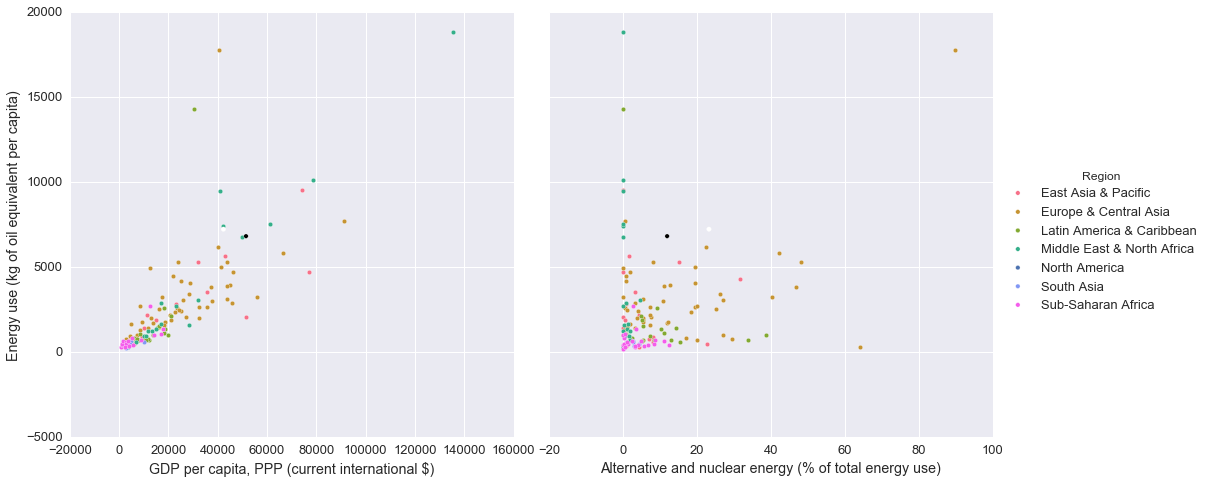

In [20]:
sns.set(font_scale=1.3)

sns.pairplot(Indicators_df[Indicators_df['Year'] == 2012]
             ,x_vars = ['GDP per capita, PPP (current international $)'
             ,'Alternative and nuclear energy (% of total energy use)']
             ,y_vars = ['Energy use (kg of oil equivalent per capita)']
             ,size = 7
             ,hue = 'Region')


#### From the the left chart, we can see that countries with higher GDP/capita also have greater variance in the energy usage per capita.  The relationship seems to weaken as the GDP increases.

#### The right chart clearly illustrates the weak relationship between renewable energy usage percentage and total energy usage.  We can see that many countries have very low renewable energy usage couples with high total energy usage while others exhibit the opposite. 

#### Now let's take a look at these relationships, but this time let's group by the income group.

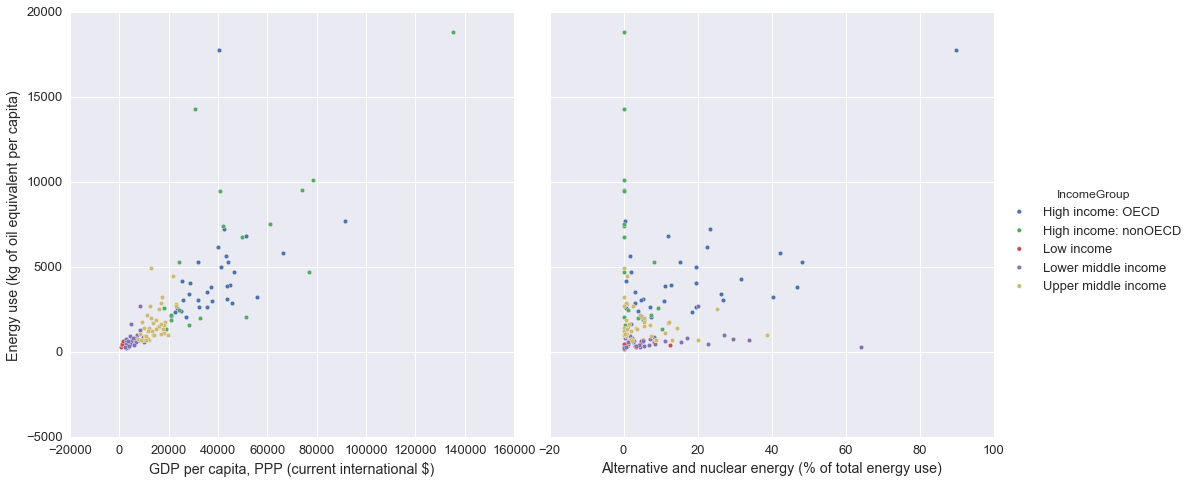

In [21]:
sns.set(font_scale=1.3)

sns.pairplot(Indicators_df[Indicators_df['Year'] == 2012]
             ,x_vars = ['GDP per capita, PPP (current international $)'
             ,'Alternative and nuclear energy (% of total energy use)']
             ,y_vars = ['Energy use (kg of oil equivalent per capita)']
             ,size = 7
             ,hue = 'IncomeGroup')


#### Not surpisingly, wealthier countries use more energy, but they also very wildly in how much of their energy comes from renewable sources.

#### So it seems that individually, these indicators cannot accurately predict total energy usage.  Let's see if we can use linear regression to predict energy assuming we know the values of the other indicators.

In [23]:
#Create a linear regression object
lreg = LinearRegression()


X_cols = Indicatorsnn_df.drop(['Year'
                               ,'Region' 
                               ,'CountryName'
                               ,'Energy use (kg of oil equivalent per capita)'
                               ,'IncomeGroup']
                              ,1)
Y_target = Indicatorsnn_df['Energy use (kg of oil equivalent per capita)']

#Implement Linear Regression
lreg.fit(X_cols, Y_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Let's take a look at our coefficients.

In [24]:
#Create a dataframe from the features
coeff_df = DataFrame(X_cols.columns)
coeff_df.columns = ['Indicators']

coeff_df["Coefficient Estimate"] = pd.Series(lreg.coef_)

coeff_df

,Indicators,Coefficient Estimate
0,Alternative and nuclear energy (% of total ene...,55.936439
1,"GDP per capita, PPP (current international $)",0.118457
2,Improved water source (% of population with ac...,45.985357
3,Internet users (per 100 people),3.846413
4,Labor force with tertiary education (% of total),5.844475
5,"Life expectancy at birth, total (years)",-143.479632


#### Interesting, now let's check the validity of our model.  We'll do this by creating a test and training sets.  The training set will be used to create our model, and it will then be tested against the test set.

In [25]:
# Grab the output and set as X and Y test and train data sets
X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(X_cols,Y_target)

In [26]:
# Create our regression object
lreg = LinearRegression()

# Once again do a linear regression, except only on the training sets this time
lreg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
# Predictions on training and testing sets
pred_train = lreg.predict(X_train)
pred_test = lreg.predict(X_test)


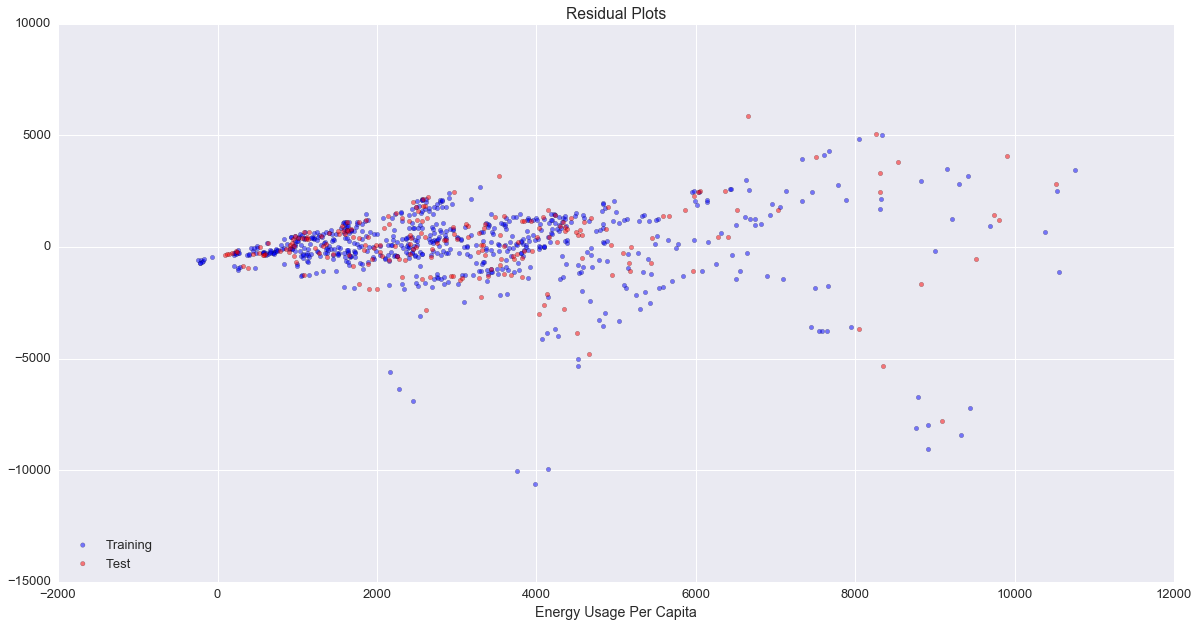

In [28]:
#Resize for imporoved visibility
plt.figure(figsize = (20,10))

# Scatter plot the training data
train = plt.scatter(pred_train,(pred_train-Y_train),c='b',alpha=0.5)

# Scatter plot the testing data
test = plt.scatter(pred_test,(pred_test-Y_test),c='r',alpha=0.5)


#Labels
plt.legend((train,test),('Training','Test'),loc='lower left')
plt.title('Residual Plots')
plt.xlabel('Energy Usage Per Capita')



#### When looking at residual plots, it's always important to observe any patterns if they exist.  A good model will result in a patternless residual plot.  For the most part, we do not see a clear pattern here, but the errors are often large relative to the actual energy usage values.  The errors tend to increase as the energy usage increases.

#### As previously mentioned, there are many ways to quantify overall development, and it's certainly a subjective characteristic.  From this, we can come to the conclusion that global development factors do heavily influence energy usage, but with these indicators alone, it's difficult to accurately predict it.  Another noteworthy insight from this analysis is the poor correlation between the predicting indicators.  One might expect a stronger relationship between college education rates with internet users.  This only underscores the overwhelming complexity that defines global development.  Strangely, it seems that for countries with greater energy usage, the indicators we used to predict it have much greater variance, which results in greater difficulty in predicting it.  This model is clearly incomplete, but it's a promising first start in examining the effects global development has on energy usage.